# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

We have given 426K data points for the price of used cars. Goal is to identify what features define the value of car. This will help dealer to predict price of used cars.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [13]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
set_config(display="diagram")

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

We need to load the data - 

In [72]:
cars = pd.read_csv('data/vehicles.csv')

In [15]:
cars.dtypes

id                int64
region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
state            object
dtype: object

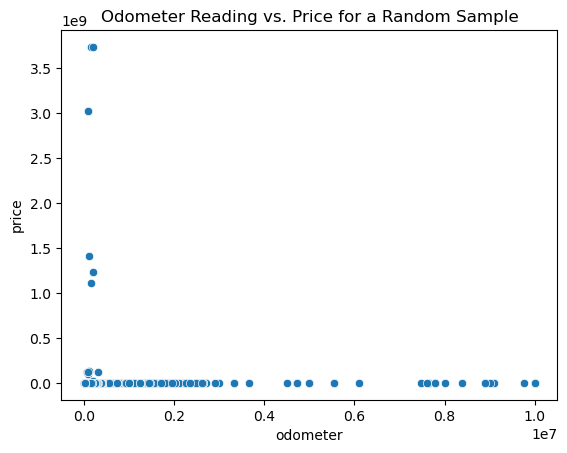

In [64]:
sns.scatterplot(x = 'odometer', y = 'price', data = cars)
plt.title("Odometer Reading vs. Price for a Random Sample")
plt.show()



In [17]:
cars.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [18]:
cars['size'].unique()

array([nan, 'full-size', 'mid-size', 'compact', 'sub-compact'],
      dtype=object)

In [19]:
cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


We need to analyze and find out, columns containing null values.

In [20]:
len(cars)

426880

In [21]:
cars.count()

id              426880
region          426880
price           426880
year            425675
manufacturer    409234
model           421603
condition       252776
cylinders       249202
fuel            423867
odometer        422480
title_status    418638
transmission    424324
VIN             265838
drive           296313
size            120519
type            334022
paint_color     296677
state           426880
dtype: int64

In [22]:
cars.isna().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [23]:
cars.nunique()

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64

In [24]:
cars.corr()

,id,price,year,odometer
id,1.000000,-0.002779,-0.059040,0.010721
price,-0.002779,1.000000,-0.004925,0.010032
year,-0.059040,-0.004925,1.000000,-0.157215
odometer,0.010721,0.010032,-0.157215,1.000000


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Dropping columns with most of the missing values

In [25]:
cars.drop(columns = ['id', 'VIN','size'], inplace = True )


In [26]:
cars.isna().sum()

region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
type             92858
paint_color     130203
state                0
dtype: int64

In [27]:
cars = cars.dropna(subset=['manufacturer'])

In [28]:
cars.isna().sum()

region               0
price                0
year                 6
manufacturer         0
model             5208
condition       167283
cylinders       169556
fuel              2553
odometer          4151
title_status      7749
transmission      2287
drive           123162
type             86372
paint_color     124152
state                0
dtype: int64

lets check condition column

In [29]:
cars.condition.unique()

array(['good', 'excellent', 'fair', nan, 'like new', 'new', 'salvage'],
      dtype=object)

we can assume that missing values in condition is fair by default

In [30]:
cars['condition'].fillna('fair', inplace = True)

In [31]:
cars.isna().sum()

region               0
price                0
year                 6
manufacturer         0
model             5208
condition            0
cylinders       169556
fuel              2553
odometer          4151
title_status      7749
transmission      2287
drive           123162
type             86372
paint_color     124152
state                0
dtype: int64

drop missing odometer value rows

In [32]:
cars = cars.dropna(subset=['odometer'])

In [33]:
cars.isna().sum()

region               0
price                0
year                 6
manufacturer         0
model             5194
condition            0
cylinders       166890
fuel              2009
odometer             0
title_status      7204
transmission      1624
drive           121804
type             85533
paint_color     122242
state                0
dtype: int64

drop rows with nan model

In [34]:
cars = cars.dropna(subset=['model'])

dont see much value in model column so drooping it

In [73]:
cars.drop(columns = ['id', 'VIN','size'], inplace = True )


lets look cylinders column now

In [36]:
cars.cylinders.value_counts()['other']

904

In [37]:
cars['title_status'].unique()


array(['clean', 'rebuilt', 'lien', nan, 'salvage', 'missing',
       'parts only'], dtype=object)

Lets defsult 'title_status',  as missing

In [38]:
cars['title_status'].fillna('missing', inplace = True)

In [39]:
cars.isna().sum()

region               0
price                0
year                 6
manufacturer         0
model                0
condition            0
cylinders       164298
fuel              2009
odometer             0
title_status         0
transmission      1608
drive           119566
type             83236
paint_color     119318
state                0
dtype: int64

In [40]:
cars.cylinders.unique()

array(['8 cylinders', '6 cylinders', nan, '4 cylinders', '5 cylinders',
       '10 cylinders', '3 cylinders', 'other', '12 cylinders'],
      dtype=object)

i see 50% of data is missing for cylinders colums, so dropping that column

drive and 

In [41]:
cars.drop(columns = ['cylinders'], inplace = True )


In [42]:
cars = cars.dropna(subset=['fuel'])

In [43]:
cars = cars.dropna(subset=['year'])

In [44]:
cars.isna().sum()

region               0
price                0
year                 0
manufacturer         0
model                0
condition            0
fuel                 0
odometer             0
title_status         0
transmission      1540
drive           119155
type             82909
paint_color     118766
state                0
dtype: int64

In [45]:
cars.drive.unique()

array([nan, 'rwd', '4wd', 'fwd'], dtype=object)

dropping drive column as i dont see much value, only 3 tyypes avaliable 

In [46]:
cars.drop(columns = ['drive'], inplace = True )


In [47]:
cars.drop(columns = ['paint_color'], inplace = True )


In [48]:
cars.isna().sum()

region              0
price               0
year                0
manufacturer        0
model               0
condition           0
fuel                0
odometer            0
title_status        0
transmission     1540
type            82909
state               0
dtype: int64

In [49]:
cars.transmission.unique()

array(['other', 'automatic', 'manual', nan], dtype=object)

In [50]:
cars = cars.dropna(subset=['transmission'])

In [51]:
cars.isna().sum()

region              0
price               0
year                0
manufacturer        0
model               0
condition           0
fuel                0
odometer            0
title_status        0
transmission        0
type            82907
state               0
dtype: int64

In [52]:
cars['type'].unique()

array(['pickup', 'truck', 'other', nan, 'coupe', 'SUV', 'hatchback',
       'mini-van', 'sedan', 'offroad', 'van', 'convertible', 'wagon',
       'bus'], dtype=object)

In [53]:
cars['type'].fillna('other', inplace = True)

In [54]:
cars.isna().sum()

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
fuel            0
odometer        0
title_status    0
transmission    0
type            0
state           0
dtype: int64

now we have cleared all nan values, lets see how we can convert the columns to numaric

In [55]:
cars.nunique()

region             404
price            15141
year               107
manufacturer        41
model            22873
condition            6
fuel                 5
odometer        101072
title_status         6
transmission         3
type                13
state               51
dtype: int64

In [56]:
cars.dtypes

region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
fuel             object
odometer        float64
title_status     object
transmission     object
type             object
state            object
dtype: object

convert to multi column if there are less unique values

In [57]:
cars2 = pd.get_dummies(cars,columns = ['fuel', 'condition', 'transmission', 'title_status'])
cars2 = cars2.reset_index()
cars2.info(verbose = True)
cars2.drop(columns = 'index', inplace= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396334 entries, 0 to 396333
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   index                    396334 non-null  int64  
 1   region                   396334 non-null  object 
 2   price                    396334 non-null  int64  
 3   year                     396334 non-null  float64
 4   manufacturer             396334 non-null  object 
 5   model                    396334 non-null  object 
 6   odometer                 396334 non-null  float64
 7   type                     396334 non-null  object 
 8   state                    396334 non-null  object 
 9   fuel_diesel              396334 non-null  uint8  
 10  fuel_electric            396334 non-null  uint8  
 11  fuel_gas                 396334 non-null  uint8  
 12  fuel_hybrid              396334 non-null  uint8  
 13  fuel_other               396334 non-null  uint8  
 14  cond

for rest create LabelEncoder

In [58]:
from sklearn.preprocessing import LabelEncoder
labeled_cols = ['region', 'manufacturer', 'model', 'type', 'state']
cars2[labeled_cols] = cars2[labeled_cols].apply(LabelEncoder().fit_transform)
cars2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396334 entries, 0 to 396333
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   region                   396334 non-null  int64  
 1   price                    396334 non-null  int64  
 2   year                     396334 non-null  float64
 3   manufacturer             396334 non-null  int64  
 4   model                    396334 non-null  int64  
 5   odometer                 396334 non-null  float64
 6   type                     396334 non-null  int64  
 7   state                    396334 non-null  int64  
 8   fuel_diesel              396334 non-null  uint8  
 9   fuel_electric            396334 non-null  uint8  
 10  fuel_gas                 396334 non-null  uint8  
 11  fuel_hybrid              396334 non-null  uint8  
 12  fuel_other               396334 non-null  uint8  
 13  condition_excellent      396334 non-null  uint8  
 14  cond

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Lets start creating the model, we can start with simple regresison model

In [123]:
cars_X = cars2.drop(['price',], axis = 1)
cars_y = cars2['price']
cars_X_train, cars_X_test, cars_y_train, cars_y_test = train_test_split(cars_X,  cars_y, 
                                                                       test_size = 0.3,
                                                                       random_state = 42)

In [127]:
cars_y.head()

0    33590
1    22590
2    39590
3    30990
4    15000
Name: price, dtype: int64

In [126]:
cars2.corr()

,region,price,year,manufacturer,model,odometer,type,state,fuel_diesel,fuel_electric,...,condition_salvage,transmission_automatic,transmission_manual,transmission_other,title_status_clean,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage
region,1.000000,-0.001215,-0.004480,0.001667,-0.001615,-0.001744,0.003162,-0.037019,-0.006110,-0.001099,...,-0.001586,0.013584,0.002032,-0.016577,-0.001511,0.000990,0.012495,0.002374,-0.002703,-0.011598
price,-0.001215,1.000000,-0.004767,0.004043,-0.000668,0.000872,0.000602,0.000822,0.001548,-0.000209,...,-0.000192,0.000272,0.001583,-0.001301,0.000977,-0.000209,-0.000595,-0.000099,-0.000560,-0.000451
year,-0.004480,-0.004767,1.000000,0.027078,0.037772,-0.176040,0.004644,0.013266,0.000469,0.032888,...,-0.041188,-0.067494,-0.261583,0.240359,0.007149,0.007542,-0.009725,-0.034873,0.012584,-0.017324
manufacturer,0.001667,0.004043,0.027078,1.000000,-0.011993,0.000621,0.040088,-0.013314,-0.002181,0.048810,...,0.005727,-0.015820,0.048615,-0.012723,-0.015310,0.000689,0.005377,-0.002657,0.012989,0.009290
model,-0.001615,-0.000668,0.037772,-0.011993,1.000000,-0.004126,-0.096141,0.004671,-0.048219,0.015151,...,-0.004627,-0.021824,-0.006869,0.028897,0.011793,0.002299,-0.002948,-0.001384,-0.008736,-0.011615
odometer,-0.001744,0.000872,-0.176040,0.000621,-0.004126,1.000000,0.008620,-0.001986,0.037894,-0.018911,...,0.024810,0.102716,0.033024,-0.136440,-0.004911,-0.000546,0.001010,0.024376,-0.003681,0.010234
type,0.003162,0.000602,0.004644,0.040088,-0.096141,0.008620,1.000000,-0.005551,0.142041,0.003143,...,0.000914,-0.007723,-0.018116,0.020080,0.006930,-0.003328,-0.010747,0.000123,0.001077,0.000055
state,-0.037019,0.000822,0.013266,-0.013314,0.004671,-0.001986,-0.005551,1.000000,0.034158,-0.011424,...,-0.003588,0.009106,-0.001211,-0.009496,0.002601,0.005397,-0.014253,-0.001905,0.014237,-0.008097
fuel_diesel,-0.006110,0.001548,0.000469,-0.002181,-0.048219,0.037894,0.142041,0.034158,1.000000,-0.016570,...,-0.003379,0.065239,0.004869,-0.076541,0.014056,0.013028,-0.007115,-0.000452,-0.014602,-0.009495
fuel_electric,-0.001099,-0.000209,0.032888,0.048810,0.015151,-0.018911,0.003143,-0.011424,-0.016570,1.000000,...,-0.001234,-0.047622,-0.013482,0.062108,0.005379,0.006044,-0.000654,0.003098,-0.007168,-0.005674


Starting with simple LinearRegression

In [128]:
f2 = LinearRegression(fit_intercept = True)
f2.fit(cars_X, cars_y)
linreg_mse = mean_squared_error(f2.predict(cars_X), cars_y)
print(linreg_mse)

128838567499012.34


In [135]:
ols_pipe = Pipeline([('poly_features', PolynomialFeatures(degree = 2, include_bias= False)), 
                     ('linreg', LinearRegression())])
ols_pipe.fit(cars_X, cars_y)
ols_preds = ols_pipe.predict(cars_X)

ols_pipe_mse = mean_squared_error(ols_pipe.predict(cars_X), cars_y)
print(ols_pipe_mse)

128816850524365.6


scale the features and see if that make any difference 

In [140]:
scaled_pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())]).fit(cars_X, cars_y)

scaled_pipe_mse = mean_squared_error(scaled_pipe.predict(cars_X), cars_y)

scaled_pipe_mse

128838567499012.36

another model using SequentialFeatureSelector

In [142]:
selector_pipe = Pipeline([
    ('selector', SequentialFeatureSelector(LinearRegression() , n_features_to_select=6)),
    ('model', LinearRegression())
])
selector_pipe.fit(cars_X, cars_y)

selector_pipe_mse = mean_squared_error(selector_pipe.predict(cars_X), cars_y)

selector_pipe_mse

128844960283696.28

I see that 'odometer', 'year', 'manufacturer', 'model' features has highest correlation with price, so I am creating model using these features. 

In [143]:
features2 = cars2[['odometer', 'year', 'manufacturer', 'model']]
price = cars2['price']
#generate train/test data for auto
cars_X_train, cars_X_test, cars_y_train, cars_y_test = train_test_split(features2, price, 
                                                                       test_size = 0.3,
                                                                       random_state = 42)

In [144]:
lr = LinearRegression().fit(cars_X_train, cars_y_train)
model_1_train_mse = mean_squared_error(cars_y_train, lr.predict(cars_X_train))
model_1_test_mse = mean_squared_error(cars_y_test, lr.predict(cars_X_test))
print(f'Train MSE: {model_1_train_mse: .2f}')
print(f'Test MSE: {model_1_test_mse: .2f}')

Train MSE:  90702831666655.23
Test MSE:  217831643710667.81


Another model but using Ridge

In [67]:
#generate train/test data for auto
cars_X_train, cars_X_test, cars_y_train, cars_y_test = train_test_split(cars2, cars2['price'], 
                                                                       test_size = 0.3,
                                                                       random_state = 42)

In [69]:
cars2.shape

(396334, 28)

In [70]:
cars2['price'].shape

(396334,)

In [145]:
ridge = Ridge(alpha = 1)
ridge.fit(cars_X_train, cars_y_train)
ridge_train_mse = mean_squared_error(cars_y_train, ridge.predict(cars_X_train))
ridge_test_mse = mean_squared_error(cars_y_test, ridge.predict(cars_X_test))
print(f'The Ridge training MSE is: {ridge_train_mse}')
print(f'The Ridge testing MSE is: {ridge_test_mse}')

The Ridge training MSE is: 90702831666655.17
The Ridge testing MSE is: 217831643710986.66


lastly GridSearchCV with Ridge.

In [147]:
params_dict = {'alpha': [0.1, 1.0, 10.0]}

ridge = Ridge()
grid = GridSearchCV(ridge, param_grid=params_dict)
grid.fit(cars_X_train, cars_y_train)
train_preds = grid.predict(cars_X_train)
test_preds = grid.predict(cars_X_test)
train_mse = mean_squared_error(cars_y_train, train_preds)
test_mse = mean_squared_error(cars_y_test, test_preds)
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Best Params: {grid.best_params_}')


Train MSE: 90702831666655.23
Test MSE: 217831643713855.9
Best Params: {'alpha': 10.0}


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

I tried multiple ways to create model, used GridSearchCV with Ridge, used SequentialFeatureSelector, I also used PolynomialFeatures for feature selection. Based on correlation i see that 'odometer', 'year', 'manufacturer', 'model' had the most impact on price, I can see the impact of these features from the model created using these features.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Summary for Dealers:


odometer, year, manufacturer and model are 4 main features, which have the most impact on the price of used cars. 
Less milage on odometer, newer cars give high value. Also there are certain model and manufacturer has high price then others.
